# Problems in numerical earthquake modeling

Last updated Sept 9th, 2021. 

There are many many interesting problems to work on in the world of earthquake modeling and simulation. This page is intended to explain some of the interesting topics to software and numerics experts outside the field and is intended to be continually updated. Currently, it is mostly unfinished with some sections completely blank and it is too light on literature review.

At the moment, the tooling is a major limitation for the field. Improving both the algorithms and the software would be a very productive contribution. 

In particular, boundary integral equation (BIE) methods are very promising for a set of problems where the object under study is itself a boundary! So, let's focus on boundary integral (and element) methods. At the moment, the standard methodology is to use constant basis function boundary elements for [which](okada) [analytical](tdes) [solutions](qdyn) have been derived. Generally, these elements are used to represent the fault in either a fullspace or halfspace.  There are some efforts to move beyond these simple methods but those efforts have not yet panned out. The main barrier is lack of software and knowledge of appropriate algorithms. I think QBX-based integration combined with FMM or H-matrix acceleration would be very powerful.

## Target capabilities
So, what would that hypothetical BIE software look like? Let's start by just listing the types of applications that would be nice to tackle, starting with "absolutely critical" down to "nice to have".

* linear elasticity
* complex realistic geometries
    * faults
    * topography
    * material interfaces
    * fault roughness 
* large models (large enough that $O(n^2)$ methods won't work)
* high performance
* earthquake rupture modeling
* linear and nonlinear viscoelastic behavior
* elastic-plastic behavior
* seismic waves

This list is probably biased to my personal preferences and the things I've worked on so far, but also covers a huge range of problems. Solving even two or three of these bullet points would be a huge contribution!

## A starting point!

As an initial application of QBX/FMM methodology, I would propose working on a 2D antiplane earthquake rupture problem. A useful starting reference would be "Quasi‐dynamic versus fully dynamic simulations of earthquakes and aseismic slip with and without enhanced coseismic weakening" by Thomas and others. I'd especially recommend sections 2.1 and 2.2.

The basic model that has been used in the past here is that of a horizontally infinite half-space free surface above a out-of-plane infinite strike slip fault. Bear with me if these words aren't making sense. In this "antiplane shear" setting, the Navier equations of elasticity reduce to the Poisson equation. Combining this with fault frictional ODEs into a DAE system, we get an exciting but fairly simple time dependent model of earthquakes. 

Let's dig more into the details of the geometry. There are two main surfaces:
- The free surface. We assume that the atmosphere applies negligible force on the surface of the Earth. As a result, the traction on the surface is zero. Or in Poisson-speak, the potential gradient is zero. The infinite free surface, is of course problematic in a numerical setting and must be made finite. 
  - One approach is to just truncate the flat surface. However that introduces some problems because the domain is no longer closed. 
  - Another approach is to adopt a more realistic geometry and simply use an Earth-sized circle for the free surface. That also introduces problems because the length-scale of the Earth is much much larger than that of most fault systems. 
  - A third approach is to truncate the domain with some physically-justifiable far-field vertical and basal boundary conditions - basically replace the half-space with a box. This is probably the best approach in many situations, but it does require being very careful about those far-field boundary conditions. Also, doing this in a naive way will introduce some numerically annoying corners from the corners of the box. Smoothing out those corners makes the numerics easier!
- The fault. Here, we will be updating some ODEs in order to compute the slip rate. Slip on a fault is an earthquake science term for crack displacement. See below in the "Background" section for an explanation of how to deal with cracks in a BIE approach to elasticity. Ultimately, the jump in displacement requires using a hypersingular integral equation. 

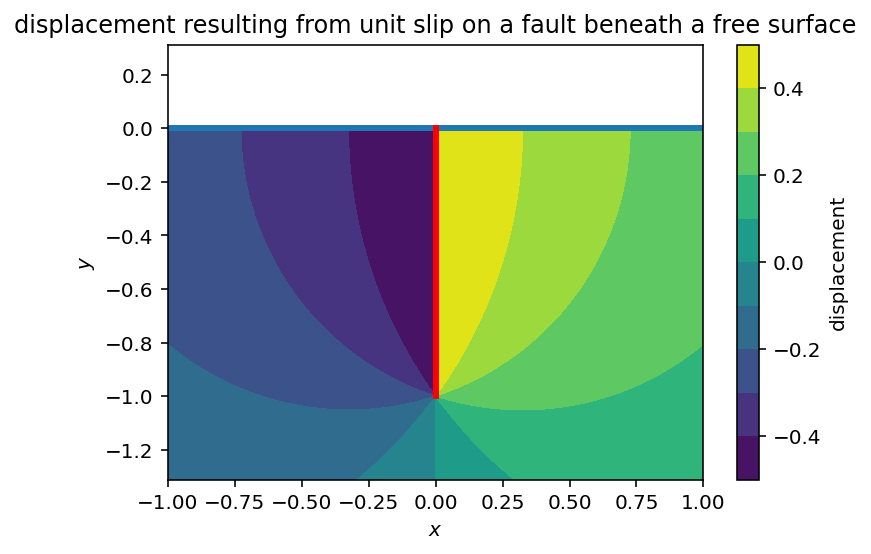

In [168]:
"""
A simple analytical solution for constant slip on a fault underneath a free surface.
See "Earthquake and Volcano Deformation", Segall chapter 2.
"""
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

N = 100
xs = np.linspace(-1, 1, N)
ys = np.linspace(-2, 0, N)
X, Y = np.meshgrid(xs, ys)

# We need to account for the fault tip and it's image across the free surface
# in order to impose zero traction on the free surface.
fault_term = np.arctan((Y - 1) / X)
image_term = np.arctan((Y + 1) / X)
u3 = -1 / (2 * np.pi) * (fault_term - image_term)

plt.plot([-10, 10], [0,0], linewidth = 3)
plt.plot([0, 0], [0, -1], 'r-', linewidth = 3)
plt.contourf(X, Y, u3, levels = np.linspace(-0.5, 0.5, 11))
plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cbar = plt.colorbar()
cbar.set_label('displacement')
plt.title('displacement resulting from unit slip on a fault beneath a free surface')
plt.show()

For many methods, the fault introduces a lot of difficulties because of the need to integrate a hypersingular kernel. QBX-based integration has none of those problems. However, there is a critical problem, *What do we do about the fault-surface intersection?* This seems closely related with corner-handling in parametrized curves. However, it actually seems a bit easier because there is no singular physical behavior.

Let's return to those ODEs that we are integrating on the fault. [I wrote an accessible introduction to a common form of fault friction here](https://tbenthompson.com/post/block_slider/) This type of *rate and state friction* is a common framework for frictional earthquake modeling. For more info, "Laboratory-Derived Friction Laws and Their Application to Seismic Faulting" by Chris Marone is a useful review that covers a lot of the study of fault friction. However, going into too much depth is probably not necessary initially. 

Ultimately, in pseudocode, an earthquake simulation will often look something like this, alternating between solving the PDEs for elasticity and solving the fault-frictional equations:
```
while not done:
    slip += velocity * dt
    fault_traction = elastic_solver(slip)
    velocity = friction_solver(fault_traction)
```

#### Test problems
I don't know of any analytical solutions for this type of earthquake simulation, but there are several useful testing avenues:
- The elastic solver can be thoroughly tested. There are a wide variety of idealized elasticity solutions. 
  - The analytical solutions for the displacement from a constant amount of slip on a line segment, triangle or rectangular are available. These are called "dislocation solutions" and are common building blocks for boudnary element methods. For line segments, see sections 2.1 and 2.2 of "Earthquake and Volcano Deformation" by Paul Segall. In 3D with constant slip on a triangle, see [the software here](https://github.com/tbenthompson/cutde) and the paper referenced there. 
  - The solution for slip on a line segment in a 2D model is particularly useful. I replicated [it using QBX-based BIE methods here](https://tbenthompson.com/book/c1qbx/part3_topo_solver.html). One specific solution that is very useful is exactly 
  - Another useful solution is that of a compressed sphere. Solutions for this problem and other similar "elementary elasticity" problems can be found in "Theory of Elasticity" by Timoshenko and Goodier. That book is a treasure trove of useful analytical test problems. 
- Several extensions of the elastic solver can be tested in special cases, for example, if the deeper regions are visco-elastic instead of elastic. 
- There is a project, "The SCEC Sequences of Earthquakes and Aseismic Slip Project" that is a community to benchmark earthquake simulation software solutions against each other. While that doesn't prove that any particular piece of software is correct, it does help to identify errors. 
- I've been working on an implementation of body force handling which would enable *method of manufactured solutions* testing.

## Example past applications

## A couple potential future applications 

The space of possibilities is huge, but I think the most exciting potential research is in geometrically realistic modeling of actual fault systems. Simulating the interaction of many faults at once would be a powerful demonstration of methodological capabilities and also have real scientific value. It would also provide a foundation for connecting a lot more empirical and observational evidence into theoretical models. 

Another area of personal interest is evaluating Lyapunov time scales for chaotic behavior in an earthquake system as a function of different parameters and physics. This would be foundational work in the study of whether earthquakes are predictable or not. 

# Notes and more details

## Linear elasticity

Let's focus on elasticity as it appears in a BIE method. If you need a more basic introduction to linear elasticity, there's a lot out there. Some terms to search are "elastostatics", "elastodynamics", "solid mechanics". (Link to some books and documents http://www.cns.gatech.edu/~predrag/GTcourses/PHYS-4421-04/lautrup/2.8/solids.pdf)

For someone coming from an applied math or numerics background, relating the concepts here to the Poisson equation can be helpful. We can extend the concept of a scalar potential into the analogous vector displacement. And extend the vector potential gradient into the tensor stress.

### Differential form

In differential form, the equations for (static, isotropic, homogeneous) linear elasticity are:

\begin{align}
\nabla \cdot \sigma &= f\\
\epsilon &= (\nabla u) + (\nabla u)^T\\
\sigma &= \lambda \delta_{ij} \epsilon_{kk} + 2\mu\epsilon_{ij}
\end{align}

where $\sigma$ is the stress tensor, $f$ is the vector body force, $\epsilon$ is the strain tensor, $u$ is the displacement vector, $\lambda$ is the Lamé parameter, $\mu$ is the shear modulus and $\delta_{ij}$ is the Kronecker delta. The first equation is a differential statement of Newton's law. The second and third statements together are a statement of infinitesimal strain linear elasticity. These equations are sometimes called the Navier equations or the Navier-Cauchy equations (not to be mistaken for the Navier-Stokes equations!!). 

### Integral form

The Somigliana identity is an integral representation of the displacements in an elastic body in terms of the displacements and stresses on the boundary of that body. We can write the Somigliana identity cleanly by adopting index notation: 

\begin{equation}
    u_{k}(\mathbf{x}) + \int_{S} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = \int_{S} U^*_{kj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} ~~~~~ \forall \mathbf{x} \in V
    \label{somigliana}
\end{equation}

where $S = \partial V$ (the boundary of $V$), $u_k(\textbf{x})$ is $k$-th component the displacement field at $\mathbf{x}$, $t_k(\textbf{x})$ is $k$-th component of the traction field (note: $t_k = \sigma_{kj} n_j$ -- the traction is "stress applied to a surface") and 

\begin{equation}
    U^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{1}{16\pi\mu(1 - \nu)r}\big[(3 - 4\nu)\delta_{kj} + r_{,k}r_{,j}\big]
\end{equation}
\begin{equation}
    T^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{-1}{8\pi(1-\nu)r^2}\big[ \{(1-2\nu)\delta_{kj} + 3r_{,k}r_{,j} \}\frac{\partial r}{\partial \mathbf{n}} - (1 - 2\nu)\{n_jr_{,k} - n_kr_{,j}\}\big]
\end{equation}

are the fundamental elastic and traction Green's functions of elasticity,
with $\delta_{ij}$ is the Kronecker delta, $\mu$ as the elastic shear modulus, $\nu$ as the poisson ratio, $\mathbf{n}$ is the normal vector to $S$ at $y$, $r = \|\mathbf{x} - \mathbf{y}\|$ and $r_{,i} = \partial r/\partial x_i$.

If traction, $t$, is known on the surface, we have Neumann problem. If displacement $u$ is known, we have a Dirichlet problem.

### Cracks 

So far, we've ignored cracks or faults in the elastic body. However, for earthquake science, these are the most important surfaces in the problem. The standard approach to treat cracks is to separate the crack into two infinitesimally separated surfaces, $C^+$ and $C^-$. Then, introducing the displacement discontinuity $\Delta u = u^+ - u^-$, enforcing force balance across the crack, $t^+ + t^- = 0$, the $U^*$ integrals cancel each other out and we get:
\begin{equation}
    \begin{split}
        u_{k}(\mathbf{x}) = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}
    \end{split}
    \label{somigliana_crack}
\end{equation}
where $F$ is the crack surface. Note that the $U^*$ integral over $F$ on the right hand side has dropped out to the force balance assumption.

For folks who've seen some potential theory, this is starting to look a lot like the double layer potential.

### Traction BIE

Critically, the traction on the fault surface does not appear in equation (\ref{somigliana_crack}). Solving for traction given fault slip is a critical step in many earthquake simulation problems. To solve this issue, another integral equation can be derived from the Somigliana identity by taking gradients and applying the elastic constitutive equations: 
\begin{equation}
    \sigma_{lk}(\mathbf{x}) - \int_{S} A^*_{lkj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} = -\int_{S} H^{*}_{lkj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} ~~~~~ \forall \mathbf{x} \in V
    \label{tractionbie}
\end{equation}
with
\begin{equation}
    A^*_{lkj}(\mathbf{x},\mathbf{y}) = \frac{1}{8\pi(1 - \nu)r^2}\big[(1 - 2\nu)\{\delta_{lj}r_{,k} + \delta{kj}r_{,l} - \delta_{lk}r_{,j}\} + 3r_{,l}r_{,k}r_{,j}\big]
\end{equation}
\begin{equation}
\begin{split}
    H^*_{lkj}(\mathbf{x},\mathbf{y}) = \frac{\mu}{4\pi(1 \nu)r^3}\big[&3\frac{\partial r}{\partial \mathbf{n}}(\{1 - 2\nu\}\delta_{lk}r_{,j} + \nu(\delta_{kj}r_{,l} + \delta_{lj}r_{,k}) - 5r_{,l}r_{,k}r_{,j})\\
    &+ (1 - 2\nu)(3n_jr_{,l}r_{,k} + n_k\delta{lj} + n_l\delta_{kj})\\
    &+ 3\nu(n_lr_{,k}r_{,j} + n_kr_{,l}r_{,j})\\
    &- (1 - 4\nu)n_m\delta_{lk} \big]
\end{split}
\end{equation}

This equation is often called the traction boundary integral equation, because in contrast to equation (\ref{somigliana}), given the boundary conditions, we calculate the traction at any interior point instead of the displacement. 

Just like the displacement boundary integral equation, we can treat cracks as two infinitesimally separated surfaces with a jump in displacement and balanced tractions. The resulting integral equation is:

\begin{equation}
    \begin{split}
        \sigma_{lk}(\mathbf{x}) = \int_{F} H^{*}_{lkj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}~~~~~ \forall \mathbf{x} \in V
    \end{split}
    \label{tractionbie_crack}
\end{equation}

While the fault traction still does not appear within any surface integrals, the point $\mathbf{x}$ can be chosen to lie on the surface $F$, giving us the stress and traction on the fault surface. As a result, in contrast to the displacement boundary integral equation, this integral equation can be used to solve for fault stress and traction and will be a fundamental component of earthquake simulation methods.

### Displacement discontinuity method

We can solve Somigliana's identity as described above directly for displacement and traction is at least one or the other is known at any point on $S$. However, it's often easier to use a double layer potential approach to represent the solution in terms of an only-sometimes-meaningful vector density $\phi(\mathbf{y})$. Given $u$ for some subset $S_u$ and $t$ for some subset $S_t$, we solve:

\begin{equation}
u_{k}(\mathbf{x}) = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \phi(\mathbf{y}) d\mathbf{y}
\end{equation}
\begin{equation}
t_{k}(\mathbf{x}) = \int_{F} H^{*}_{lkj}(\mathbf{x},\mathbf{y}) n_l \phi(\mathbf{y}) d\mathbf{y}
\end{equation}

Given that these equations are exactly the ones that we derived above for a crack, $\phi$ matches exactly with the displacement discontinuity (aka "slip") $\Delta u$ when $S$ is a crack surface. For any other surface, we can interpret $\phi$ as a sort of fictitious slip or fictitious displacement discontinuity. Then, if we want to compute displacement or traction, we can compute the result using the above integrals of $\phi$. This approach is called the "Displacement discontinuity method". 

## Complex geometries, large models and high performance

There's a lot of data on the Earth. Put a cool 3D figure here. 

### Fault roughness

Fault roughness is a particularly fascinating topic because it introduces a small scale geometrical nonlinearity into the model. 

## Quasidynamic rupture modeling

### 
TODO: Put a link to youtube video here

Quasidynamic earthquake simulation is a powerful tool for investigating the frictional behavior of faults over many earthquake cycles without having to invest the numerical resources required for fully dynamic rupture modeling \citep{rice1993spatio, liu2005aseismic, thomas2014quasi}. 

The quasidynamic approximation is a first order approximation of inertial wave effects with a "radiation damping" term. The quasidynamic shear stress on the fault surface is
\begin{equation}
    \tau_{\mathrm{qd}} = \tau_{\mathrm{static}} - \frac{\mu}{2c_s} V
\end{equation}
where $\mu$ is the shear modulus, $c_s$ is the shear wave speed, and $V$ is the local fault slip velocity. The advantage of this approximation is that the shear stress can be calculated using static elastic numerical methods and then adjusted by the slip velocity.

To complete the system, we need to a friction law that relates shear stress to slip velocity. A common framework is rate-state friction where the strength of friction is related to both the rate of slip and a state variable the evolves during fault slip. The state variable evolution law can take various forms. Here, we present the aging law. Then, rate-state friction takes the form
\begin{align}
    \tau_{\mathrm{qd}} = a\sigma_n \sinh^{-1}\left(\frac{V}{2V_0}e^{\Psi / a}\right)\label{ratestate}\\
    \frac{d\Psi}{dt} = \frac{bV_0}{D_c}\left(e^{(f_0 - \Psi) / b} - \frac{V}{V_0}\right)\label{stateevolution}
\end{align}
where $\sigma_n$ is the normal stress, $\Psi$ is the state variable, $f_0$ is a the friction coefficient at a steady state slip velocity of $V_0$, $a$ and $b$ are dimensionless parameters determining the strength of velocity and state changes respectively on the evolution of friction and $D_c$ is the state evolution length scale. In our implementation, fault slip is always parallel to the shear stress vector and can be in any direction on the fault plane. 

Several approaches have been used for quasidynamic earthquake cycle simulation. Fourier domain convolution methods are extremely efficient for planar faults with a uniform discretization \citep{rice1993spatio, lapusta2000elastodynamic}. However, these methods break down in the face of any non-planarity. Boundary element methods using rectangular or triangular dislocations \citep{liu2005aseismic, segall2012slow} have the aforementioned stress singularity issues, especially on nonplanar faults. Both Fourier and dislocation approaches struggle with rheologies beyond linear elasticity. In comparison, finite difference methods or finite element methods can successfully model a much wider range of rheologies including non-uniform material properties \citep{erickson2014efficient} or viscoplasticity \citep{allison2018earthquake}. However, finite difference methods still have difficulty with complex nonplanar fault geometries. In comparison, our boundary element methods can model arbitrary nonplanar fault geometries.

We build a quasidynamic earthquake cycle simulator on top of Tectosaur. We track the current slip deficit and state variable at every degree of freedom on the fault surface. Then, at each time step, we calculate the traction on the fault surface from the slip deficit field using Tectosaur to solve the static elastic equations. The friction equations are then solved for the current slip velocity using Equation (\ref{ratestate}). The state derivatives are calculated using Equation (\ref{stateevolution}). Finally, having both the slip deficit derivatives and state derivatives, we integrate in time. The algorithm is flexible to the particular time integration method. A popular method has been to use a time step dependent on the fastest slip velocity on the fault \citep{lapusta2009three}. We follow \citet{erickson2014efficient} in using an adaptive Runge-Kutta algorithm. 

## Viscoelastic behavior and elasto-plastic behavior

The Earth is not purely elastic and there are many settings.

DEFINE A MAXWELL RHEOLOGY

DEFINE A SIMPLE PLASTIC RHEOLOGY

Change the fundamental material behavior seems like it would require a new set of basic equations, but given the mild perturbation away from elasticity, it's also possible to push the extra physics into the "body force" term. 

## Seismic waves

## Fully dynamic rupture modeling